In [1]:
import numpy as np
import scipy.optimize as op
import matplotlib.pylab as plt
%matplotlib inline

In [99]:
import os
import shutil
import cPickle as cpkl
import csv

In [141]:
# setup object contains inputs of necessary parameters for code
class setup(object):
    """
    setup object specifies all parameters controlling one run of p(z) inference program
    """
    def __init__(self,input_address='hogg'):

        self.inadd = input_address
        self.testdir = os.path.join('..','tests')
        self.datadir = os.path.join(self.testdir,input_address)

        self.name = 'Hogg\'s Test'

        # take in specification of bins if provided, otherwise make some

        self.allnbins = 35
        binstep = 1. / self.allnbins
        self.allzs = np.arange(0.,1.+binstep,binstep)

        # his, los, centers of bins and bin widths handy for plotting
        self.allzlos = self.allzs[:-1]
        self.allzhis = self.allzs[1:]
        self.allzmids = (self.allzhis + self.allzlos) / 2
        self.zdifs = self.allzhis - self.allzlos
        self.zdif = sum(self.zdifs) / self.allnbins

        # define a physical P(z)
        # for sum of Gaussians, elements of the form (z_center, spread, magnitude)
        # take in specification of underlying P(z) if provided, otherwise make one
        self.zrange = max(self.allzs)-min(self.allzs)
        self.zmin = min(self.allzs)
        self.zmax = max(self.allzs)
        
        self.real = np.array([[self.zmin+0.2*self.zrange, 0.08, 0.3],
                         [self.zmin+0.4*self.zrange, 0.06, 0.4],
                         [self.zmin+0.6*self.zrange, 0.06, 0.2],
                         [self.zmin+0.8*self.zrange, 0.1, 0.1]
                          ])

        self.surv = 1e4
#         self.poisson = bool(1)
#         self.random = bool(1)
#         self.interim = 'flat'#corresponding to 'flat','unimodal','bimodal','multimodal'#bool(0)
#         self.sigma = bool(0)
        self.noisefact = 2
#         self.shape = 1
#         self.outlier = 0
        self.degen = 1
#         self.noise = bool(0)

        # colors for plots
#         self.colors='brgycm'

        self.topdir = os.path.join(self.testdir,self.inadd)
        if os.path.exists(self.topdir):
            shutil.rmtree(self.topdir)
        os.makedirs(self.topdir)

        self.simdir = os.path.join(self.topdir,'data')
        if os.path.exists(self.simdir):
            shutil.rmtree(self.simdir)
        os.makedirs(self.simdir)

        print(self.name+' ingested inputs')
        
meta = setup()

Hogg's Test ingested inputs


In [2]:
class gauss(object):
    
    def __init__(self,mean,sigma,amp=1.):
        self.mean = mean
        self.sigma = sigma
        self.amp = amp
        
    def evaluate_one(self,z):
        p = 0.
        if z>0. and z<1.:
            p = self.amp / (np.sqrt(2. * np.pi) * self.sigma) * \
                np.exp(-0.5 * (z - self.mean) ** 2 / self.sigma ** 2)
        return p
        
    def evaluate(self,zs):
        ps = np.zeros_like(zs)
        for n,z in enumerate(zs):
            ps[n] += self.evaluate_one(z)#+= self.amp / (np.sqrt(2. * np.pi) * self.sigma) * \
                                #np.exp(-0.5 * (z - self.mean) ** 2 / self.sigma ** 2)
        #ps[zs < 0.] = 0.
        #ps[zs > 1.] = 0.
        return ps

In [4]:
class gmix(object):
    
    def __init__(self,means,sigmas,amps=np.ones(1)):
        self.means = means
        self.sigmas = sigmas
        self.amps = amps
        self.amps /= np.sum(self.amps)
        self.cumamps = np.cumsum(self.amps)
        
    def sample(self):
        z = -1.#z=z_true here
        while z < 0. or z > 1.:
            r = np.random.uniform(0., self.cumamps[-1])
            c = 0
            for k in range(1, len(self.cumamps)):
                if r > self.cumamps[k-1]:
                    c = k
            z = self.means[c] + self.sigmas[c] * np.random.normal()
        return z
    
    def evaluate(self,zs):
        """
        Doesn't return properly normalized fuunction.
        """
        ps = np.zeros_like(zs)
        for c in range(len(self.amps)):
            dist = gauss(self.means[c],self.sigmas[c],self.amps[c])
            ps += dist.evaluate(zs)#self.amps[c] * / (np.sqrt(2. * np.pi) * self.sigmas[c]) * \
                #np.exp(-0.5 * (zs - self.means[c]) ** 2 / self.sigmas[c] ** 2)
        ps[zs < 0.] = 0.
        ps[zs > 1.] = 0.
        return ps

In [142]:
np.random.seed(meta.allnbins)#42)
N = int(meta.surv)#2 ** 16

truemeans = meta.real.T[0]#np.array([0.5, 0.2, 0.75])
truesigmas = meta.real.T[1]#np.array([0.4, 0.2, 0.1])
trueamps = meta.real.T[2]#np.array([0.20, 0.35, 0.55])
truedist = gmix(truemeans,truesigmas,trueamps)
trueamps = truedist.amps#/= np.sum(trueamps)
cumamps = truedist.cumamps#np.cumsum(trueamps)

In [105]:
def sample_true_prior(N):
    print("Making ztrue values...")
    ztrues = np.array([truedist.sample() for n in range(N)])
    return ztrues

In [155]:
ztrues = sample_true_prior(N)

with open(os.path.join(meta.simdir,'logtrue.csv'),'wb') as csvfile:
    out = csv.writer(csvfile,delimiter=' ')
    truZs = [[z] for z in ztrues]
    for item in truZs:
        out.writerow(item)

nplot = meta.surv
bplot = meta.allnbins
zplot = np.arange(0.5 / nplot, 1.0, 1.0 / nplot)

Making ztrue values...


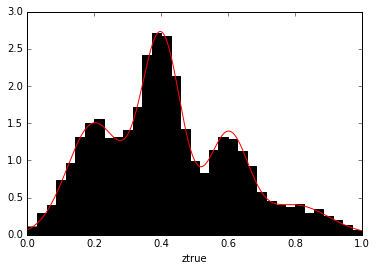

In [156]:
plt.clf()
plt.hist(ztrues, bins=bplot, normed=True, color="k")
plt.plot(zplot, truedist.evaluate(zplot), "r-")
plt.xlabel("ztrue")
#plt.savefig("ztrues.png")

In [9]:
class likelihood(object):
    
    def __init__(self,sigma,outlier_mean=0.,outlier_sigma=1.,outlier_frac=0.):
        self.sigma = sigma
        self.ofrac = outlier_frac
        self.omean = outlier_mean
        self.osigma = outlier_sigma
        
    def sample(self,z):#z=z_true here
        if np.random.uniform() < self.ofrac:
            mean = np.array([self.omean])
            sigma = np.array([self.osigma])
            self.dist = gmix(mean,sigma)
        else:
            mean = np.array([z])
            sigma = np.array([self.sigma])
            self.dist = gmix(mean,sigma)
        return self.dist.sample()
    
    def evaluate(self,zobs,zs):#zs=ztrues here
        ps = np.zeros_like(zs)
        self.odist = gauss(self.omean,self.osigma,self.ofrac)
        ps += self.odist.evaluate(zobs)
        for n,z in enumerate(zs):
            dist = gauss(z,self.sigma,1.-self.ofrac)
            ps[n] += dist.evaluate(zobs)
            #print(ps[n])
        ps[zs < 0.] = 0.
        ps[zs > 1.] = 0.
        return ps

In [145]:
true_lf_sigma = 0.05
true_lf_outlier_fraction = 0.2
true_lf_outlier_mean = 0.4
true_lf_outlier_sigma = 0.075

lf = likelihood(true_lf_sigma,
                true_lf_outlier_mean,true_lf_outlier_sigma,true_lf_outlier_fraction)

zobss = np.array([lf.sample(ztrue) for ztrue in ztrues])

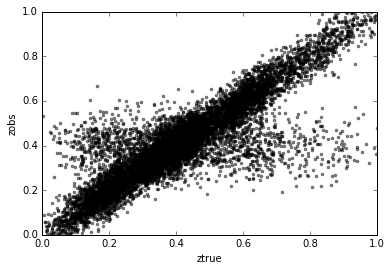

In [146]:
plt.clf()
plt.plot(ztrues, zobss, "k.", alpha=0.5)
plt.xlabel("ztrue")
plt.ylabel("zobs")
#plt.savefig("scatter.png")

In [12]:
class prior(object):
    
    def __init__(self,name='flat'):
        self.name = name
        
    def evaluate(self,zs):#zs=z_trues here
        if self.name == 'flat':
            ps = np.ones_like(zs)
            ps[zs < 0.] = 0.
            ps[zs > 1.] = 0.
        return ps
    
    def make_binned(self,grid):
        return self.evaluate(grid)

In [147]:
K = meta.allnbins
binfactor = meta.allnbins
KK = K * binfactor # number of fine bins
interimprior = prior()

dzfine = 1. / KK
zfine = np.arange(0.5 * dzfine, 1.0, dzfine)
interimfine = interimprior.evaluate(zfine)

dzcoarse = 1. / K
zcoarse = np.arange(0.5 * dzcoarse, 1.0, dzcoarse)
interimcoarse = interimprior.evaluate(zcoarse)

In [14]:
class posterior(object):
    def __init__(self,prior,likelihood,grid):
        self.prior = prior
        self.likelihood = likelihood
        
        self.coarse = grid
        self.dcoarse,self.ncoarse = self.dgrid(self.coarse)
        
        self.nfine = self.ncoarse**2
        self.dfine = self.dcoarse/self.ncoarse
        self.fine = np.arange(0.5 * self.dfine, 1.0, self.dfine)
        
        self.factor = self.nfine/self.ncoarse
        
    def dgrid(self,grid):
        ngrid = len(grid)
        gridrange = grid[1:]-grid[:-1]
        dg = np.sum(gridrange)/(ngrid-1)
        return dg,ngrid

    def make_binned(self,z):#z=zobs here
        """
        stupidly slow, but only called once.
        """
        ps = self.prior.make_binned(self.fine) * self.likelihood.evaluate([z], self.fine)
        ps /= np.sum(ps) * self.dfine
        coarseps = np.array([np.sum(ps[k * self.factor : (k + 1) * self.factor]) * \
                             self.dfine for k in range(self.ncoarse)])
        return coarseps / self.dcoarse

    def make_rectangular(self,zobss):
        ps = np.zeros((len(zobss), self.ncoarse))
        for n,zobs in enumerate(zobss):
            ps[n] = self.make_binned(zobs)
        return ps

In [148]:
post = posterior(interimprior,lf,zcoarse)

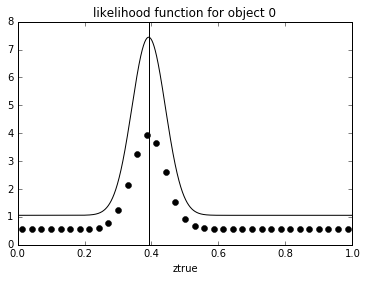

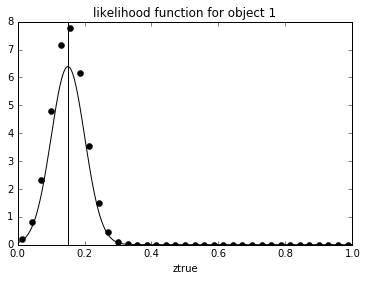

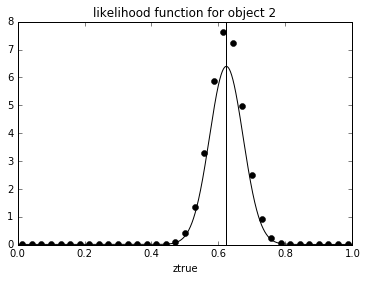

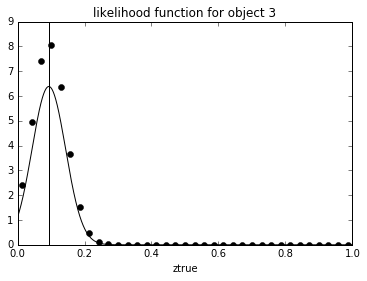

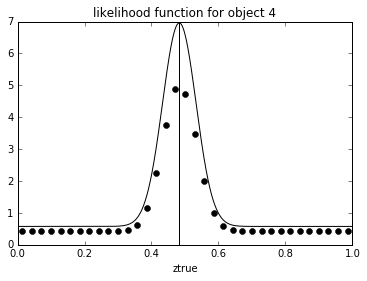

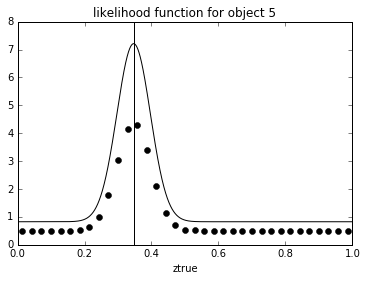

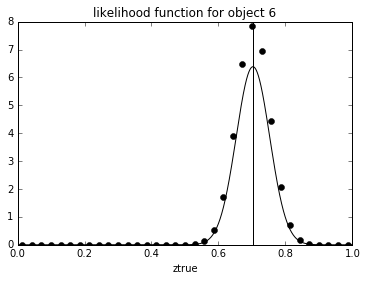

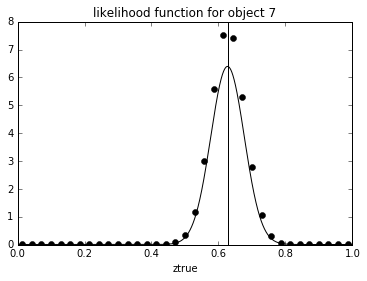

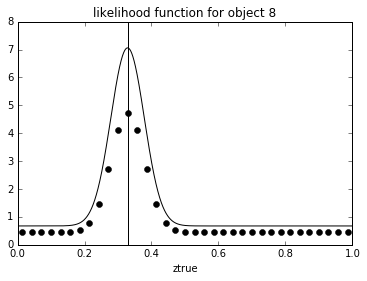

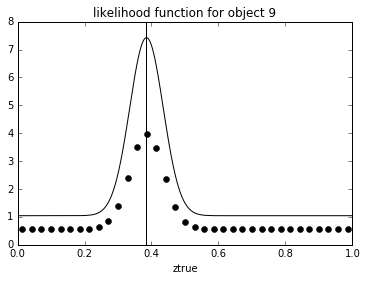

In [149]:
for n,zobs in enumerate(zobss[:10]):
    plt.clf()
    #print(lf.evaluate([zobs], zplot))
    #print(post.make_binned(zobs))
    plt.plot(zplot, lf.evaluate([zobs], zplot), "k-")
    plt.plot(zcoarse, post.make_binned(zobs), "ko")
    plt.axvline(zobs, color="k")
    plt.xlabel("ztrue")
    plt.xlim(0., 1.)
    plt.title("likelihood function for object {}".format(n))
    plt.show()
    #plt.savefig("lf_{:02d}.png".format(n))

In [150]:
data = post.make_rectangular(zobss)

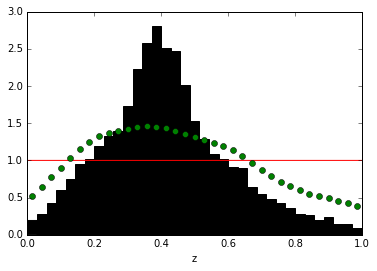

In [151]:
plt.clf()
plt.hist(zobss, bins=bplot, normed=True, color="k")
plt.plot(zplot, interimprior.evaluate(zplot), "r-")
plt.plot(zcoarse, np.sum(data, axis=0) / N, "go")
plt.xlabel("z")
#plt.savefig("zobs.png")

In [153]:
import csv
#print(data[:10])
with open(os.path.join(meta.simdir,'logdata.csv'),'wb') as csvfile:
    out = csv.writer(csvfile,delimiter=' ')
    out.writerow(meta.allzs)
    out.writerow(interimcoarse)
    for line in data:
        out.writerow(np.log(line))

[[  5.69216659e-01   5.69216659e-01   5.69216666e-01   5.69216873e-01
    5.69221394e-01   5.69292538e-01   5.70099413e-01   5.76676175e-01
    6.15022853e-01   7.73698636e-01   1.23305029e+00   2.13693563e+00
    3.26312528e+00   3.93796930e+00   3.63509397e+00   2.59983388e+00
    1.54789126e+00   9.12378004e-01   6.56732886e-01   5.85444555e-01
    5.71403672e-01   5.69430787e-01   5.69231883e-01   5.69217445e-01
    5.69216688e-01   5.69216660e-01   5.69216659e-01   5.69216659e-01
    5.69216659e-01   5.69216659e-01   5.69216659e-01   5.69216659e-01
    5.69216659e-01   5.69216659e-01   5.69216659e-01]
 [  2.17572284e-01   8.29519552e-01   2.33248061e+00   4.78554595e+00
    7.15033139e+00   7.77751119e+00   6.15823806e+00   3.55006568e+00
    1.49118719e+00   4.58348142e-01   1.05703720e-01   2.14172118e-02
    7.11551022e-03   5.37927616e-03   5.22777515e-03   5.21824664e-03
    5.21781395e-03   5.21779974e-03   5.21779941e-03   5.21779940e-03
    5.21779940e-03   5.21779940e-03 

In [157]:
prior_var = np.eye(K)
for k in range(K):
    prior_var[k] = 1. * np.exp(-0.5 * (zcoarse[k] - zcoarse) ** 2 / 0.10 ** 2)
#print(prior_var)
prior_ivar = np.linalg.inv(prior_var)
#print(np.shape(prior_ivar))

In [95]:
class hyperdist(object):
    
    def __init__(self,interim,data,ivar,dz):
        
        self.interim = interim
        self.data = data
        self.ivar = ivar
        self.dz = dz
        
    def optimize(self):
        def _objective(pars):
            return -2. * self.lnposterior(pars)
        guess = np.sum(self.data, axis=0)
        guess /= np.sum(guess) * self.dz
        guess = np.log(guess)
        print("starting at", guess, _objective(guess))
        res = op.minimize(_objective, guess, method="Nelder-Mead",
                          options={"maxfev": 1e5, "maxiter":1e4})
        print(res)
        return res
    
    def lnposterior(self,lnamps):
        out = self.lnprior(lnamps) + self.lnlf(lnamps)
        #print('lnposterior='+str(out))
        return out
    
    def lnprior(self,lnamps):
        """
        Stupid Gaussian prior.
        """
        out = -0.5 * np.dot(np.dot(self.ivar, lnamps), lnamps)
        #print('lnprior='+str(out))
        return out
    
    def lnlf(self,lnamps):
        return np.sum(np.log(self.lfs(lnamps)))
    
    def lfs(self,lnamps):
        amps = np.exp(lnamps - np.max(lnamps))
        amps /= np.sum(amps)
        return np.sum(amps[None,:] * self.data / self.interim[None,:], axis=1)

In [158]:
hyper = hyperdist(interimcoarse,data,prior_ivar,dzcoarse)

guess = np.log(truedist.evaluate(zcoarse))
print("hyperposterior at truth:", hyper.lnposterior(guess))
guess = np.log(interimcoarse)
#print('guess shape='+str(np.shape(guess))+' with guess='+str(guess))
print("hyperposterior at interim prior:", hyper.lnposterior(guess))
res = hyper.optimize()
themap = np.exp(res.x)
themap /= np.sum(themap) * dzcoarse

('hyperposterior at truth:', -1128659086565.1021)
('hyperposterior at interim prior:', -1.3350431871117507e-12)
('starting at', array([-0.64900198, -0.44250478, -0.26021818, -0.10209648,  0.03351933,
        0.14399311,  0.22596501,  0.28060641,  0.3145627 ,  0.33697549,
        0.3549953 ,  0.36986464,  0.37732364,  0.37317036,  0.35759105,
        0.33367391,  0.304457  ,  0.27307174,  0.24277649,  0.21373805,
        0.18008786,  0.13177601,  0.06110692, -0.03084267, -0.13417251,
       -0.23781204, -0.33669541, -0.42999536, -0.51570335, -0.59093511,
       -0.6557721 , -0.71484946, -0.77687727, -0.85259269, -0.94817876]), 132733.86685529081)
 final_simplex: (array([[ -3.35871274e+26,   3.70999195e+27,   3.92121368e+27, ...,
          3.18025151e+26,  -2.44549974e+26,  -7.38686720e+26],
       [ -3.11922996e+26,   3.44546227e+27,   3.64162348e+27, ...,
          2.95349336e+26,  -2.27113083e+26,  -6.86016913e+26],
       [ -3.09435475e+26,   3.41798542e+27,   3.61258229e+27, ...,
  

/Users/aimalz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp
/Users/aimalz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in divide


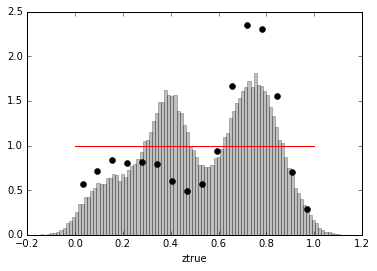

In [97]:
plt.clf()
plt.hist(zobss, bins=bplot, normed=True, color="k", alpha=0.25)
plt.plot(zplot, interimprior.evaluate(zplot), "r-")
plt.plot(zcoarse, themap, "ko")
plt.xlabel("ztrue")
#plt.savefig("map.png")

[[  1.00000000e+00   8.22577562e-01   4.57833362e-01   1.72421624e-01
    4.39369336e-02   7.57567744e-03   8.83826307e-04   6.97695772e-05
    3.72665317e-06   1.34686969e-07   3.29371411e-09   5.45004313e-11
    6.10193668e-13   4.62263041e-15   2.36954175e-17   8.21851355e-20]
 [  8.22577562e-01   1.00000000e+00   8.22577562e-01   4.57833362e-01
    1.72421624e-01   4.39369336e-02   7.57567744e-03   8.83826307e-04
    6.97695772e-05   3.72665317e-06   1.34686969e-07   3.29371411e-09
    5.45004313e-11   6.10193668e-13   4.62263041e-15   2.36954175e-17]
 [  4.57833362e-01   8.22577562e-01   1.00000000e+00   8.22577562e-01
    4.57833362e-01   1.72421624e-01   4.39369336e-02   7.57567744e-03
    8.83826307e-04   6.97695772e-05   3.72665317e-06   1.34686969e-07
    3.29371411e-09   5.45004313e-11   6.10193668e-13   4.62263041e-15]
 [  1.72421624e-01   4.57833362e-01   8.22577562e-01   1.00000000e+00
    8.22577562e-01   4.57833362e-01   1.72421624e-01   4.39369336e-02
    7.57567744e-0

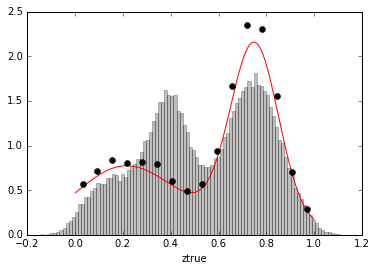

In [42]:
"""
Code to take non-trivial p(z|d) data and infer dN/dz..
"""
import numpy as np
import scipy.optimize as op

trueamps = np.array([0.20, 0.35, 0.55])
trueamps /= np.sum(trueamps)
cumamps = np.cumsum(trueamps)
truemeans = np.array([0.5, 0.2, 0.75])
truesigmas = np.array([0.4, 0.2, 0.1])

def make_one_ztrue():
    ztrue = -1.
    while ztrue < 0. or ztrue > 1.:
        r = np.random.uniform(0., cumamps[-1])
        c = 0
        for k in range(1, len(cumamps)):
            if r > cumamps[k-1]:
                c = k
        ztrue = truemeans[c] + truesigmas[c] * np.random.normal()
    return ztrue

def sample_true_prior(N):
    print("Making ztrue values...")
    ztrues = np.array([make_one_ztrue() for n in range(N)])
    return ztrues

def evaluate_true_prior(zs):
    """
    Doesn't return properly normalized fuunction.
    """
    ps = np.zeros_like(zs)
    for c in range(len(trueamps)):
        ps += trueamps[c] / (np.sqrt(2. * np.pi) * truesigmas[c]) * \
            np.exp(-0.5 * (zs - truemeans[c]) ** 2 / truesigmas[c] ** 2)
    ps[zs < 0.] = 0.
    ps[zs > 1.] = 0.
    return ps

true_lf_sigma = 0.05
true_lf_outlier_fraction = 0.2
true_lf_outlier_mean = 0.4
true_lf_outlier_sigma = 0.075

def sample_likelihood(ztrue):
    if np.random.uniform() < true_lf_outlier_fraction:
        return true_lf_outlier_mean + true_lf_outlier_sigma * np.random.normal()
    return ztrue + true_lf_sigma * np.random.normal()

def evaluate_likelihood(zobs, ztrues):
    """
    assumes zobs is a scalar and ztrues is a vector.
    """
    ps = np.zeros_like(ztrues)
    ps += true_lf_outlier_fraction / (np.sqrt(2. * np.pi) * true_lf_outlier_sigma) * \
        np.exp(-0.5 * (zobs - true_lf_outlier_mean) ** 2 / true_lf_outlier_sigma ** 2)
    ps += (1. - true_lf_outlier_fraction) / (np.sqrt(2. * np.pi) * true_lf_sigma) * \
        np.exp(-0.5 * (zobs - ztrues) ** 2 / true_lf_sigma ** 2)
    return ps

def evaluate_interim_prior(ztrues):
    ps = np.ones_like(ztrues)
    ps[ztrues < 0.] = 0.
    ps[ztrues > 1.] = 0.
    return ps

K = 16
binfactor = 16
KK = K * binfactor # number of fine bins
dzfine = 1. / KK
zfine = np.arange(0.5 * dzfine, 1.0, dzfine)
interimfine = evaluate_interim_prior(zfine)
dzcoarse = 1. / K
zcoarse = np.arange(0.5 * dzcoarse, 1.0, dzcoarse)
interim = evaluate_interim_prior(zcoarse)

def get_binned_interim_posterior(zobs):
    """
    stupidly slow, but only called once.
    """
    ps = interimfine * evaluate_likelihood(zobs, zfine)
    ps /= np.sum(ps) * dzfine
    coarseps = np.array([np.sum(ps[k * binfactor : (k + 1) * binfactor]) * dzfine for k in range(K)])
    return coarseps / dzcoarse

def get_rectangular_data(zobss):
    ps = np.zeros((len(zobss), K))
    for n,zobs in enumerate(zobss):
        ps[n] = get_binned_interim_posterior(zobs)
    return ps

def hyper_lfs(data, lnamps):
    amps = np.exp(lnamps - np.max(lnamps))
    amps /= np.sum(amps)
    return np.sum(amps[None,:] * data / interim[None,:], axis=1)

def hyper_lnlf(data, lnamps):
    return np.sum(np.log(hyper_lfs(data, lnamps)))

prior_var = np.eye(K)
for k in range(K):
    prior_var[k] = 1. * np.exp(-0.5 * (zcoarse[k] - zcoarse) ** 2 / 0.10 ** 2)
print(prior_var)
prior_ivar = np.linalg.inv(prior_var)
print('prior_ivar shape='+str(np.shape(prior_ivar)))

def hyper_lnprior(lnamps):
    """
    Stupid Gaussian prior.
    """
    out = -0.5 * np.dot(np.dot(prior_ivar, lnamps), lnamps)
    #print('lnprior='+str(out))
    return out

def hyper_lnposterior(lnamps, data):
    out = hyper_lnprior(lnamps) + hyper_lnlf(data, lnamps)
    #print('lnposterior='+str(out))
    return out

def optimize_lnposterior(data):
    def _objective(pars, data):
        return -2. * hyper_lnposterior(pars, data)
    guess = np.sum(data, axis=0)
    guess /= np.sum(guess) * dzcoarse
    guess = np.log(guess)
    print("starting at", guess, _objective(guess, data))
    res = op.minimize(_objective, guess, args=(data, ), method="Nelder-Mead",
                      options={"maxfev": 1e5, "maxiter":1e4})
    print(res)
    return res

if __name__ == "__main__":
    import matplotlib.pylab as plt
    np.random.seed(42)
    N = 2 ** 16

    ztrues = sample_true_prior(N)
    nplot = 1000
    zplot = np.arange(0.5 / nplot, 1.0, 1.0 / nplot)
    plt.clf()
    plt.hist(ztrues, bins=100, normed=True, color="k")
    plt.plot(zplot, evaluate_true_prior(zplot), "r-")
    plt.xlabel("ztrue")
    plt.savefig("ztrues.png")

    zobss = np.array([sample_likelihood(ztrue) for ztrue in ztrues])
    data = get_rectangular_data(zobss)
    plt.clf()
    plt.plot(ztrues, zobss, "k.", alpha=0.5)
    plt.xlabel("ztrue")
    plt.ylabel("zobs")
    plt.savefig("scatter.png")

    plt.clf()
    plt.hist(zobss, bins=100, normed=True, color="k")
    plt.plot(zplot, evaluate_true_prior(zplot), "r-")
    plt.plot(zcoarse, np.sum(data, axis=0) / N, "go")
    plt.xlabel("z")
    plt.savefig("zobs.png")

    for n,zobs in enumerate(zobss[:10]):
        plt.clf()
        plt.plot(zplot, evaluate_likelihood(zobs, zplot), "k-")
        plt.plot(zcoarse, get_binned_interim_posterior(zobs), "ko")
        plt.axvline(zobs, color="k")
        plt.xlabel("ztrue")
        plt.xlim(0., 1.)
        plt.title("likelihood function for object {}".format(n))
        plt.savefig("lf_{:02d}.png".format(n))

    guess = np.log(evaluate_true_prior(zcoarse))
    print("hyperposterior at truth:", hyper_lnposterior(guess, data))
    guess = np.log(interim)
    print('guess shape='+str(np.shape(guess))+' with guess='+str(guess))
    print("hyperposterior at interim prior:", hyper_lnposterior(guess, data))
    res = optimize_lnposterior(data)
    map = np.exp(res.x)
    map /= np.sum(map) * dzcoarse

    plt.clf()
    plt.hist(zobss, bins=100, normed=True, color="k", alpha=0.25)
    plt.plot(zplot, evaluate_true_prior(zplot), "r-")
    plt.plot(zcoarse, map, "ko")
    plt.xlabel("ztrue")
    plt.savefig("map.png")
